# Task 1: Subjectivity in News Articles

## Task Description

Systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.
This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).
The task comprises three settings:

* Monolingual: train and test on data in a given language L

* Multilingual: train and test on data comprising several languages

* Zero-shot: train on several languages and test on unseen languages

### Contents of the Task 1 Directory

* Main folder: data

  Contains a subfolder for each language which contain the data as TSV format with .tsv extension (train_LANG.tsv, dev_LANG.tsv, dev_test_LANG.tsv, test_LANG.tsv). As LANG we used standard language code for each language.

* Main folder: baseline

  Contains a single file, baseline.py, used to train a baseline and provide predictions.

* Main folder: scorer

  Contains a single file, evaluate.py, that checks the format of a submission and evaluate the various metrics.

### Input Data Format
The data will be provided as a TSV file with three columns:

    sentence_id  sentence  label

Where:

* sentence_id: sentence id for a given sentence in a news article

* sentence: sentence's text

* label: OBJ and SUBJ


Examples:

    b9e1635a-72aa-467f-86d6-f56ef09f62c3  Gone are the days when they led the world in recession-busting SUBJ
    f99b5143-70d2-494a-a2f5-c68f10d09d0a  The trend is expected to reverse as soon as next month.  OBJ

### Output Data Format
The output must be a TSV format with two columns: sentence_id and label.

### Evaluation Metrics
This task is evaluated as a classification task. We will use the F1-macro measure for the ranking of teams.
We will also measure Precision, Recall, and F1 of the SUBJ class and the macro-averaged scores.


### Scorers
To evaluate the output of your model which should be in the output format required, please run the script below:

    python evaluate.py -g dev_truth.tsv -p dev_predicted.tsv

where dev_predicted.tsv is the output of your model on the dev set, and dev_truth.tsv is the golden label file provided by us.
The file can be used also to validate the format of the submission, simply use the provided test file as gold data.
The evaluation will not be performed, but the format of your input will be checked.

### Baselines
The script to train the baseline is provided in the related directory.
The script can be run as follow:

    python baseline.py -trp train_data.tsv -ttp dev_data.tsv

where train_data.tsv is the file to be used for training and dev_data.tsv is the file on which doing the prediction.
The baseline is a logistic regressor trained on a Sentence-BERT multilingual representation of the data.

## Data Loading

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn.functional as F

from collections import Counter
from datasets import Dataset
from operator import itemgetter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TextClassificationPipeline
from tqdm import tqdm

C:\Users\trap9\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONFIG

dev_sets = {
    "en": "english/dev_test_en.tsv",
    "it": "italian/dev_test_it.tsv",
    "multi": "multilingual/dev_test_multilingual.tsv"
}

test_sets = {
    "mono_en_test_predictions.tsv": ("en", "english/test_en_labeled.tsv", "Mono-English"),
    "mono_it_test_predictions.tsv": ("it", "italian/test_it_labeled.tsv", "Mono-Italian"),
    "multilingual_test_predictions.tsv": ("multilingual", "multilingual/test_multilingual_labeled.tsv", "Multilingual"),
    "zero_shot_pol_predictions.tsv": ("pol", "polish/test_pol_labeled.tsv", "ZS-Polish"),
    "zero_shot_ro_predictions.tsv": ("ro", "romanian/test_ro_labeled.tsv", "ZS-Romanian"),
    "zero_shot_ukr_predictions.tsv": ("ukr", "ukrainian/test_ukr_labeled.tsv", "ZS-Ukrainian")
}

test_key_map = {
    "en": "en", "it": "it", "multilingual": "multi", "pol": "multi", "ro": "multi", "ukr": "multi"
}

model_roots = {
    "distilmbert": "models/distilmbert_models",
    "infoxlm": "models/infoxlm_models",
    "mbert": "models/mbert_models",
    "minilm": "models/minilm_models",
    "xlm_roberta": "models/xlm_roberta_models"
}

pred_dirs = {
    "distilmbert": "predictions/distilmbert_predictions",
    "infoxlm": "predictions/infoxlm_predictions",
    "mbert": "predictions/mbert_predictions",
    "minilm": "predictions/minilm_predictions",
    "xlm_roberta": "predictions/xlm_roberta_predictions"
}

label_map = {"SUBJ": 0, "OBJ": 1, "LABEL_0": 0, "LABEL_1": 1}
reverse_label_map = {0: "SUBJ", 1: "OBJ"}
output_root = "predictions"

In [3]:
# UTILS

def evaluate_f1(gold, pred):
    gold = [0 if l == "SUBJ" else 1 for l in gold]
    pred = [0 if l == "SUBJ" else 1 for l in pred]
    return f1_score(gold, pred, average='macro')

def read_predictions(model_dir, test_file):
    df = pd.read_csv(f"{model_dir}/{test_file}", sep="\t")
    return df.set_index("sentence_id")["label"]

def majority_vote(*pred_lists):
    return [Counter(votes).most_common(1)[0][0] for votes in zip(*pred_lists)]

def load_model_preds(pred_dirs, pred_file):
    preds = []
    for model in ["distilmbert", "infoxlm", "mbert", "minilm", "xlm_roberta"]:
        df = pd.read_csv(f"{pred_dirs[model]}/{pred_file}", sep="\t").set_index("sentence_id")
        preds.append(df["label"].map(label_map).tolist())
    return np.stack(preds, axis=1), df.index

def predict_with_probability_averaging(model_dirs, test_df, tokenizer_path=None):
    all_probs = []

    for model_dir in model_dirs:
        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        tokenizer = AutoTokenizer.from_pretrained(model_dir)

        encodings = tokenizer(
            list(test_df["sentence"]),
            truncation=True,
            padding=True,
            max_length=512,  # or model.config.max_position_embeddings
            return_tensors="pt"
        )

        # DistilBERT doesn't support token_type_ids
        if 'token_type_ids' in encodings and 'token_type_ids' not in model.forward.__code__.co_varnames:
            del encodings['token_type_ids']

        encodings = {k: v.to(model.device) for k, v in encodings.items()}
        model.to(model.device)
        model.eval()

        with torch.no_grad():
            outputs = model(**encodings)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()
            all_probs.append(probs)

    avg_probs = sum(all_probs) / len(all_probs)
    preds = avg_probs.argmax(axis=1)

    return preds

def run_inference(model_path, test_df):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=0)

    predictions = []
    for sentence in tqdm(test_df["sentence"], desc=f"Running inference on {model_path}"):
        pred = pipe(sentence, truncation=True, max_length=512)[0]["label"]
        predictions.append(pred)
    return predictions

In [4]:
# Run Inference on Dev Sets

for lang_key, dev_path in dev_sets.items():
    df = pd.read_csv(f"data/{dev_path}", sep="\t")
    assert "sentence_id" in df.columns and "sentence" in df.columns, f"{dev_path} must have sentence_id and sentence columns"

    for model_name, model_root in model_roots.items():
        model_dir = f"{model_root}/{model_name}-subjectivity-{lang_key}"
        out_dir = os.path.join(output_root, f"{model_name}_predictions")
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, f"dev_test_{lang_key}.tsv")  # consistent filename

        if os.path.exists(out_path):
            print(f"Skipping {model_dir} — predictions already exist at {out_path}")
            continue

        if not os.path.exists(model_dir):
            print(f"Skipping missing model: {model_dir}")
            continue

        preds = run_inference(model_dir, df)
        
        output_df = pd.DataFrame({
            "sentence_id": df["sentence_id"],
            "label": preds
        })
        output_df.to_csv(out_path, sep="\t", index=False)
        print(f"Saved: {out_path}")

Skipping models/distilmbert_models/distilmbert-subjectivity-en — predictions already exist at predictions\distilmbert_predictions\dev_test_en.tsv
Skipping models/infoxlm_models/infoxlm-subjectivity-en — predictions already exist at predictions\infoxlm_predictions\dev_test_en.tsv
Skipping models/mbert_models/mbert-subjectivity-en — predictions already exist at predictions\mbert_predictions\dev_test_en.tsv
Skipping models/minilm_models/minilm-subjectivity-en — predictions already exist at predictions\minilm_predictions\dev_test_en.tsv
Skipping models/xlm_roberta_models/xlm_roberta-subjectivity-en — predictions already exist at predictions\xlm_roberta_predictions\dev_test_en.tsv
Skipping models/distilmbert_models/distilmbert-subjectivity-it — predictions already exist at predictions\distilmbert_predictions\dev_test_it.tsv
Skipping models/infoxlm_models/infoxlm-subjectivity-it — predictions already exist at predictions\infoxlm_predictions\dev_test_it.tsv
Skipping models/mbert_models/mbert-

In [5]:
# Train Meta Classifier (Stacking)

X_train_stack, y_train_stack = [], []

for lang_key, dev_path in dev_sets.items():
    pred_file = f"dev_test_{lang_key}.tsv"
    X_dev, idx = load_model_preds(pred_dirs, pred_file)
    gold_df = pd.read_csv(f"data/{dev_path}", sep="\t").set_index("sentence_id")
    y_dev = gold_df.loc[idx]["label"].map(label_map).tolist()
    
    X_train_stack.append(X_dev)
    y_train_stack.extend(y_dev)

X_train_stack = np.vstack(X_train_stack)
y_train_stack = np.array(y_train_stack)

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_train_stack, y_train_stack)

LogisticRegression(max_iter=1000)

In [6]:
top3_models_per_setting = {}

for lang_key, dev_path in dev_sets.items():
    print(f"Evaluating dev set: {lang_key}")
    gold_df = pd.read_csv(f"data/{dev_path}", sep="\t").set_index("sentence_id")
    gold_labels = gold_df["label"].tolist()

    model_f1s = {}

    for model_name in model_roots.keys():
        pred_file = f"dev_test_{lang_key}.tsv"
        pred_path = os.path.join(pred_dirs[model_name], pred_file)
       
        if not os.path.exists(pred_path):
            print(f"Missing prediction file: {pred_path}")
            continue

        pred_df = pd.read_csv(pred_path, sep="\t").set_index("sentence_id")
        try:
            pred_labels = pred_df.loc[gold_df.index]["label"].tolist()
            pred_labels = [reverse_label_map[label_map[l]] for l in pred_labels]
        except KeyError as e:
            print(f"Sentence ID mismatch in {pred_path}: {e}")
            continue
        
        f1 = evaluate_f1(gold_labels, pred_labels)
        model_f1s[model_name] = f1

    # Select top-3 models for this language setting
    top3 = sorted(model_f1s, key=model_f1s.get, reverse=True)[:3]
    top3_models_per_setting[lang_key] = top3
    print(f"Top-3 models for {lang_key}: {top3}")

Evaluating dev set: en
Top-3 models for en: ['mbert', 'distilmbert', 'xlm_roberta']
Evaluating dev set: it
Top-3 models for it: ['xlm_roberta', 'minilm', 'mbert']
Evaluating dev set: multi
Top-3 models for multi: ['xlm_roberta', 'infoxlm', 'mbert']


In [7]:
# Evaluate on Final Test Sets

final_scores = []

for pred_file, (test_key, gold_path, test_name) in test_sets.items():
    # Read predictions
    distil_pred = read_predictions(pred_dirs["distilmbert"], pred_file)
    infoxlm_pred = read_predictions(pred_dirs["infoxlm"], pred_file)
    mbert_pred = read_predictions(pred_dirs["mbert"], pred_file)
    minilm_pred = read_predictions(pred_dirs["minilm"], pred_file)
    xlmr_pred  = read_predictions(pred_dirs["xlm_roberta"], pred_file)
    
    assert distil_pred.index.equals(infoxlm_pred.index)
    assert distil_pred.index.equals(mbert_pred.index)
    assert distil_pred.index.equals(minilm_pred.index)
    assert distil_pred.index.equals(xlmr_pred.index)

    # Load gold labels
    gold_df = pd.read_csv(f"data/{gold_path}", sep="\t").set_index("sentence_id")
    gold_labels = gold_df.loc[distil_pred.index]["label"]

    # Evaluate individual models
    distil_f1 = evaluate_f1(gold_labels.tolist(), distil_pred.tolist())
    infoxlm_f1 = evaluate_f1(gold_labels.tolist(), infoxlm_pred.tolist())
    mbert_f1 = evaluate_f1(gold_labels.tolist(), mbert_pred.tolist())
    minilm_f1 = evaluate_f1(gold_labels.tolist(), minilm_pred.tolist())
    xlmr_f1 = evaluate_f1(gold_labels.tolist(), xlmr_pred.tolist())

    scores = [distil_f1, infoxlm_f1, mbert_f1, minilm_f1, xlmr_f1]
    all_model_names = ["distilmbert", "infoxlm", "mbert", "minilm", "xlm_roberta"]

    model_preds = {
        "distilmbert": distil_pred.tolist(),
        "infoxlm": infoxlm_pred.tolist(),
        "mbert": mbert_pred.tolist(),
        "minilm": minilm_pred.tolist(),
        "xlm_roberta": xlmr_pred.tolist()
    }

    top3_models = top3_models_per_setting[test_key_map[test_key]]

    # Majority Voting with Top-3
    ensemble_pred_mv = majority_vote(*(model_preds[m] for m in top3_models))
    ensemble_mv_f1 = evaluate_f1(gold_labels.tolist(), ensemble_pred_mv)

    # Probability Averaging with Top-3
    model_dirs = [
        f"{model_roots[m]}/{'-'.join([m, 'subjectivity', test_key_map[test_key]])}"
        for m in top3_models
    ]
    ensemble_pred_pa_n = predict_with_probability_averaging(model_dirs, gold_df.reset_index(), model_dirs[0])
    ensemble_pred_pa = [reverse_label_map[p] for p in ensemble_pred_pa_n]
    ensemble_pa_f1 = evaluate_f1(gold_labels.tolist(), ensemble_pred_pa)

    # Stacking with Top-3
    top3_indices = [all_model_names.index(name) for name in top3_models]
    X_train_top3 = X_train_stack[:, top3_indices]

    meta_clf_best = LogisticRegression(max_iter=1000)
    meta_clf_best.fit(X_train_top3, y_train_stack)

    X_test_stack, _ = load_model_preds(pred_dirs, pred_file)
    X_test_top3 = X_test_stack[:, top3_indices]

    ensemble_pred_st_n = meta_clf_best.predict(X_test_top3).tolist()
    ensemble_pred_st = [reverse_label_map[p] for p in ensemble_pred_st_n]
    ensemble_st_f1 = evaluate_f1(gold_labels.tolist(), ensemble_pred_st)

    # Append Scores
    final_scores.append([
        test_name, distil_f1, infoxlm_f1, mbert_f1, minilm_f1, xlmr_f1,
        ensemble_mv_f1, ensemble_pa_f1, ensemble_st_f1
    ])

    # Save Predictions
    for name, preds in zip(
        ["mv", "pa", "st"],
        [ensemble_pred_mv, ensemble_pred_pa, ensemble_pred_st]
    ):
        out_path = f"predictions/ensemble_predictions/ensemble_{name}_{pred_file}"
        pd.DataFrame({"sentence_id": distil_pred.index, "label": preds}).to_csv(out_path, sep="\t", index=False)

## Evaluation and Error Analysis

### Utils

In [8]:
# !pip install evaluate
# !pip install seaborn

In [9]:
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

In [10]:
# Metrics
f1_metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    result = f1_metric.compute(predictions=preds, references=labels, average="macro")
    return {"f1_macro": result["f1"]}

def plot_confusion_matrix(model, results):
    cm = confusion_matrix(results["true_label"], results["predicted_label"], labels=[0, 1])
    cmd = ConfusionMatrixDisplay(cm, display_labels=["Subjective", "Objective"])
    cmd.plot(cmap="Blues")
    plt.xlabel('Predicted Label', fontsize=18, labelpad=14)
    plt.ylabel('True Label', fontsize=18, labelpad=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
#    plt.title(f"{model}: Confusion Matrix")
#    plt.savefig(f"outputs/cm_{model}.png", bbox_inches='tight')
    plt.show()

    cm = confusion_matrix(results["true_label"], results["predicted_label"], labels=[0, 1], normalize='all')
    cmd = ConfusionMatrixDisplay(cm, display_labels=["Subjective", "Objective"])
    cmd.plot(cmap="Blues")
    plt.xlabel('Predicted Label', fontsize=18, labelpad=14)
    plt.ylabel('True Label', fontsize=18, labelpad=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
#    plt.title(f"{model}: Normalized Confusion Matrix")
#    plt.savefig(f"outputs/cm_{model}_norm.png", bbox_inches='tight')
    plt.show()

def plot_precision_recall_curve(model, precision, recall, average_precision):
    # Plot the Precision-Recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model}: Precision-Recall Curve (AP = {average_precision:.2f})')
    # plt.savefig(f"outputs/pr_curve_{model}.png")
    plt.show()

### General Comparison

In [11]:
column_names=["Test Set", "distilBERT", "InfoXLM", "mBERT", "MiniLM", "XLM-RoBERTa", "Ensemble (MV)", "Ensemble (AP)", "Ensemble (ST)"]
df_all = pd.DataFrame(data=final_scores, columns=column_names)

In [12]:
df_all

,Test Set,distilBERT,InfoXLM,mBERT,MiniLM,XLM-RoBERTa,Ensemble (MV),Ensemble (AP),Ensemble (ST)
0,Mono-English,0.696120,0.417476,0.699337,0.568826,0.603501,0.705439,0.687674,0.603501
1,Mono-Italian,0.695662,0.606675,0.712876,0.737060,0.732636,0.758384,0.755844,0.758384
2,Multilingual,0.682332,0.698220,0.647332,0.659832,0.683810,0.683877,0.695843,0.683877
3,ZS-Polish,0.644309,0.580728,0.566868,0.551922,0.580900,0.578490,0.559502,0.578490
4,ZS-Romanian,0.779072,0.724341,0.738729,0.767322,0.786604,0.781344,0.784067,0.781344
5,ZS-Ukrainian,0.585378,0.628589,0.587854,0.612183,0.624288,0.616968,0.624865,0.616968


### Monolingual

#### English - MV

In [13]:
gold_file = "data/english/test_en_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_mv_mono_en_test_predictions.tsv"

In [14]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.7054
            macro-P: 0.7078
            macro-R: 0.7033
            
            SUBJ-F1: 0.5749
            SUBJ-P: 0.5854
            SUBJ-R: 0.5647
            
            accuracy: 0.7633
        


In [15]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [16]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [17]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [18]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 37

EXAMPLES:

	That sounds worryingly similar to the vainglorious delivery timetable once claimed during the sorry saga called HS2.

	If Timbaland releases a number one hit soon, we can get the full 2006 experience again.

	The release this week of the new Chinese artificial intelligence (AI) tool, DeepSeek-R1, is one such moment.

	She complains of an ‘illness’, though we’re not sure whether it’s physical or mental: it seems porous, like it has seeped into every cell of her body.

	Cuba Sí, Bloqueo No

	HS2 was not a failure because it included a tunnel or because it attempted to protect animal life; it failed because rail privatisation stripped the UK of the skills and public capacity to develop large-scale projects.

	Andersson is rigidly focused on the ‘stuff people care about.’

	Arbitrary cuts to migration, which Reeves touted in her speech, pose challenges for sectors where there are already labour shortages, including construction.

	The o

In [19]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 34

EXAMPLES:

	But Andersson is adamant that what she calls ‘red green’ politics is the only way forward — for both pragmatic and ideological reasons.

	I need  no, crave  more silence in my life.

	I would soothe my loneliness and isolation in the evenings by playing endless hours of Law & Order: Special Victims Unit just for the ambient sound – the comfort of Detectives Olivia Benson and Elliot Stabler bringing criminals of the worst kind to justice.

	Another opponent then is still a dissenter now.

	It must look elsewhere to make up for lost Russian gas.

	But here we can really see what these parties do when they are in power.

	You might have read the quote Unemployment hurts governments, inflation kills them.

	And because of everything that has happened [with the far-right government], we now have a lot in common in terms of policy.

	The fuel for the far right comes from disillusionment.

	It is wishing into existence a UK ‘Silicon

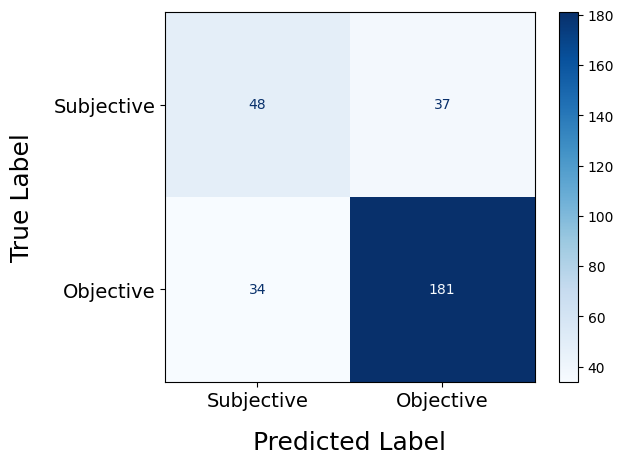

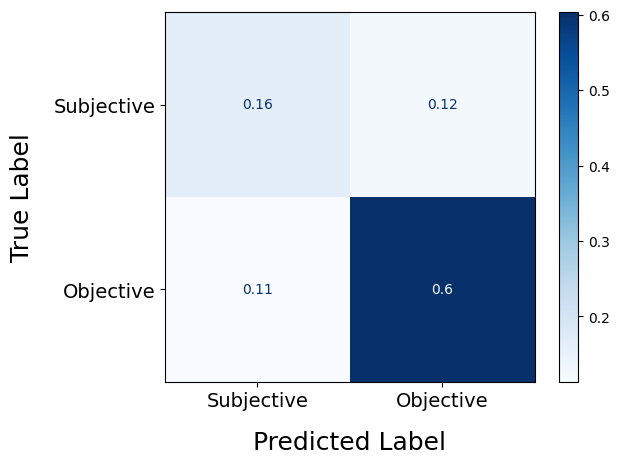

In [20]:
plot_confusion_matrix("ensemble", test_results)

#### English - PA

In [21]:
gold_file = "data/english/test_en_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_pa_mono_en_test_predictions.tsv"

In [22]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.6877
            macro-P: 0.6976
            macro-R: 0.6808
            
            SUBJ-F1: 0.5409
            SUBJ-P: 0.5811
            SUBJ-R: 0.5059
            
            accuracy: 0.7567
        


In [23]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [24]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [25]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [26]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 42

EXAMPLES:

	That sounds worryingly similar to the vainglorious delivery timetable once claimed during the sorry saga called HS2.

	If Timbaland releases a number one hit soon, we can get the full 2006 experience again.

	Both are young, charismatic, intelligent women seen as modernisers within their respective parties.

	The release this week of the new Chinese artificial intelligence (AI) tool, DeepSeek-R1, is one such moment.

	She complains of an ‘illness’, though we’re not sure whether it’s physical or mental: it seems porous, like it has seeped into every cell of her body.

	Cuba Sí, Bloqueo No

	These examples are indicative, however, of what Labour could actually be doing — rebuilding state capacity after decades of austerity and privatisation.

	HS2 was not a failure because it included a tunnel or because it attempted to protect animal life; it failed because rail privatisation stripped the UK of the skills and public capacity to devel

In [27]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 31

EXAMPLES:

	But Andersson is adamant that what she calls ‘red green’ politics is the only way forward — for both pragmatic and ideological reasons.

	I need  no, crave  more silence in my life.

	I would soothe my loneliness and isolation in the evenings by playing endless hours of Law & Order: Special Victims Unit just for the ambient sound – the comfort of Detectives Olivia Benson and Elliot Stabler bringing criminals of the worst kind to justice.

	Another opponent then is still a dissenter now.

	But here we can really see what these parties do when they are in power.

	You might have read the quote Unemployment hurts governments, inflation kills them.

	And because of everything that has happened [with the far-right government], we now have a lot in common in terms of policy.

	The fuel for the far right comes from disillusionment.

	It is wishing into existence a UK ‘Silicon Valley’ in Oxford and Cambridge, dogged by infighting, tr

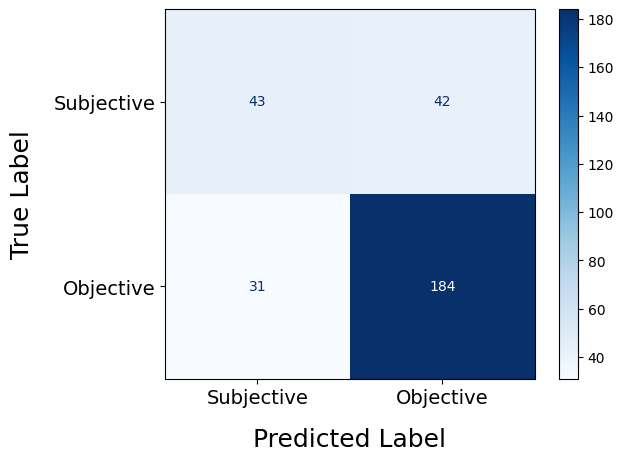

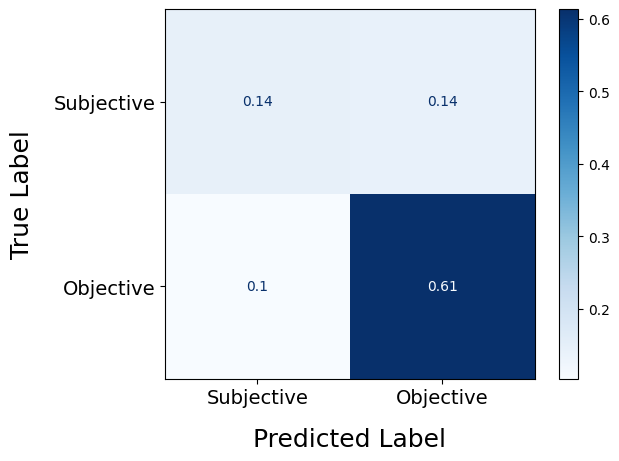

In [28]:
plot_confusion_matrix("ensemble", test_results)

#### English - ST

In [29]:
gold_file = "data/english/test_en_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_st_mono_en_test_predictions.tsv"

In [30]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.6035
            macro-P: 0.6155
            macro-R: 0.5986
            
            SUBJ-F1: 0.4079
            SUBJ-P: 0.4627
            SUBJ-R: 0.3647
            
            accuracy: 0.7000
        


In [31]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [32]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [33]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [34]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 54

EXAMPLES:

	That sounds worryingly similar to the vainglorious delivery timetable once claimed during the sorry saga called HS2.

	If Timbaland releases a number one hit soon, we can get the full 2006 experience again.

	Hostile fire was instant, will be continuous for years ahead and comes from several camps with which Labour has wanted to be friendly.

	since the US failed to confront it head-on during the Bay of Pigs invasion, it has instead kept Cuba in stasis, trapped in that moment before the celebrations can truly begin.

	I suspect that the Net Zero Secretary thinks that resignation would be a pointless gesture of opposition to something that may well not happen and certainly not anytime soon.

	Both are young, charismatic, intelligent women seen as modernisers within their respective parties.

	The release this week of the new Chinese artificial intelligence (AI) tool, DeepSeek-R1, is one such moment.

	She complains of an ‘illness’, t

In [35]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 36

EXAMPLES:

	But Andersson is adamant that what she calls ‘red green’ politics is the only way forward — for both pragmatic and ideological reasons.

	Labour’s plan for growth — with deregulation and corporate-driven projects at its core — runs the risk of deepening inequality and handing over national infrastructure to private profit.

	If investors can be found to stump up that kind of cash, they will want a return.

	But here we can really see what these parties do when they are in power.

	The "warrior prince won more than most", but "even he could not meet the full price of justice".

	And because of everything that has happened [with the far-right government], we now have a lot in common in terms of policy.

	The fuel for the far right comes from disillusionment.

	It is wishing into existence a UK ‘Silicon Valley’ in Oxford and Cambridge, dogged by infighting, trying to get a controversial Heathrow expansion over the line, and leaning i

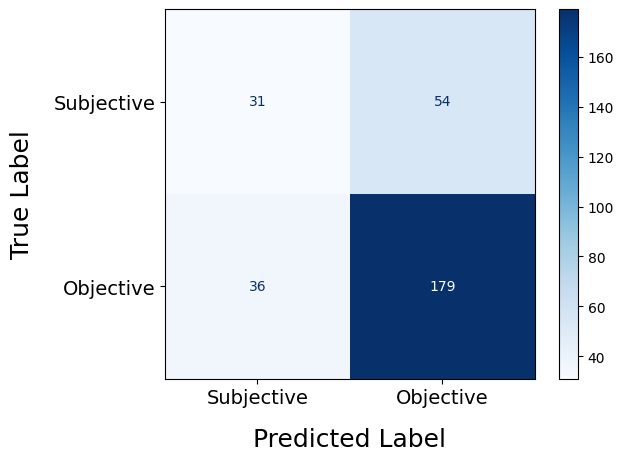

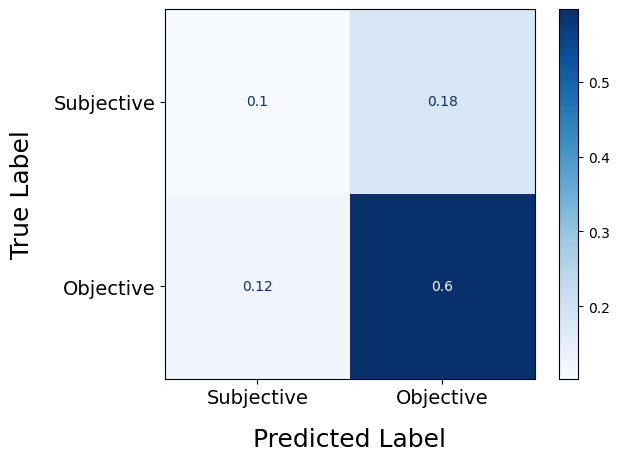

In [36]:
plot_confusion_matrix("ensemble", test_results)

#### Italian - MV

In [37]:
gold_file = "data/italian/test_it_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_mv_mono_it_test_predictions.tsv"

In [38]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.7584
            macro-P: 0.7720
            macro-R: 0.7506
            
            SUBJ-F1: 0.6768
            SUBJ-P: 0.7363
            SUBJ-R: 0.6262
            
            accuracy: 0.7860
        


In [39]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [40]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [41]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [42]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 40

EXAMPLES:

	Tempo al tempo vedremo.

	L'ostentazione della burineria e servizi montani penosi.

	Poi il leader M5S è durissimo con il ministro Nordio:

	Conte infanga Meloni?

	Il Repower-EU ha provato a tracciare la rotta in merito all’indipendenza energetica, che tutto è tranne che autosufficienza dell’UE.

	Poi fatte le olimpiadi verrà abbondonata.

	Il sindaco Gianluca Lorenzi (domani a Milano per la festa dei -365 giorni alle Olimpiadi) si toglie un sassolino dalla scarpa («Tutti esaltavano il ghiaccio naturale di St. Moritz e volevano spostare i Giochi lì, ma la prova di Coppa del Mondo è stata appena cancellata per il caldo») e poi delinea un cronoprogramma super ambizioso:

	Capisco le polemiche, i soldi in gioco sono tanti, ma se c’è un luogo nelle Alpi che merita una pista è Cortina con i suoi cent’anni di tradizione bobbistica».

	l’offerta di Lake Placid che aveva ingolosito il Cio e umiliato noi italiani (viaggi e alberghi per gli 

In [43]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 24

EXAMPLES:

	Dare del tu e chiamarsi per nome, a seconda del contesto, della relazione esistente tra i parlanti, e di molti altri fattori variabili, possono essere un modo per esprimere empatia oppure un modo di interloquire inappropriato e irrispettoso.

	Meno di 100 anni fa, le donne non potevano votare, e sembrava normale, nello stesso modo in cui oggi sembra normale vedere un autobus nel traffico.

	In questo quadro di competizione e guerra che coinvolge innanzitutto il mercato energetico, la narrazione Italiana costruita dal Governo Meloni sulla “sicurezza energetica” si inserisce perfettamente.

	E' quindi ipotizzabile che si assista a una fase in cui oro e dollaro si muovono nella stessa direzione, senza necessariamente influenzarsi a vicenda.

	Tuttavia, questa relazione si è notevolmente attenuata.

	L’attitudine a darsi del tu e chiamarsi per nome più spesso che in passato non implica che sia sempre appropriato e inoffensivo farlo

	La

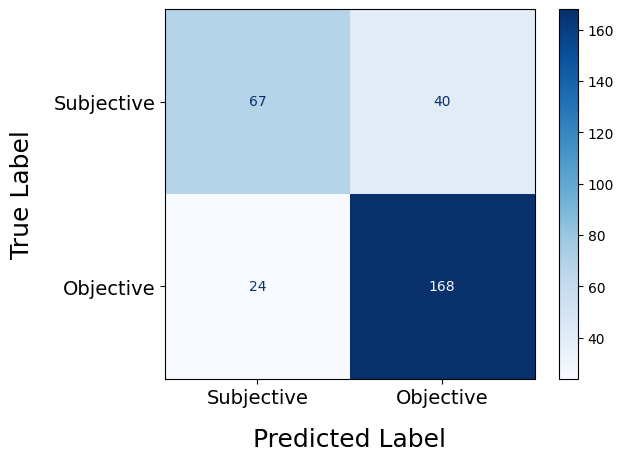

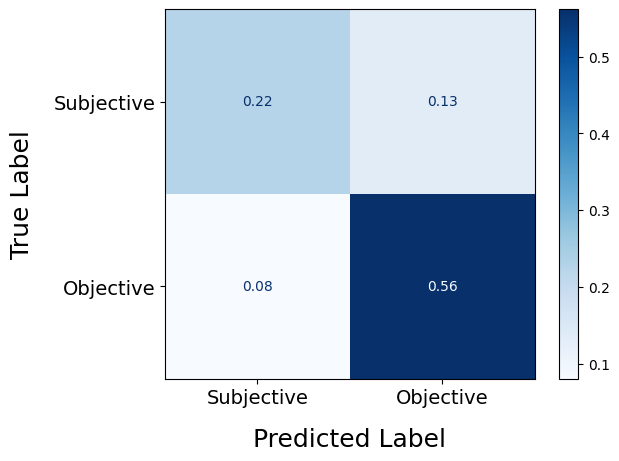

In [44]:
plot_confusion_matrix("ensemble", test_results)

#### Italian - PA

In [45]:
gold_file = "data/italian/test_it_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_pa_mono_it_test_predictions.tsv"

In [46]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.7558
            macro-P: 0.7745
            macro-R: 0.7464
            
            SUBJ-F1: 0.6701
            SUBJ-P: 0.7471
            SUBJ-R: 0.6075
            
            accuracy: 0.7860
        


In [47]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [48]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [49]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [50]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 42

EXAMPLES:

	Tempo al tempo vedremo.

	L'ostentazione della burineria e servizi montani penosi.

	Poi il leader M5S è durissimo con il ministro Nordio:

	Conte infanga Meloni?

	Il Repower-EU ha provato a tracciare la rotta in merito all’indipendenza energetica, che tutto è tranne che autosufficienza dell’UE.

	Poi fatte le olimpiadi verrà abbondonata.

	Il sindaco Gianluca Lorenzi (domani a Milano per la festa dei -365 giorni alle Olimpiadi) si toglie un sassolino dalla scarpa («Tutti esaltavano il ghiaccio naturale di St. Moritz e volevano spostare i Giochi lì, ma la prova di Coppa del Mondo è stata appena cancellata per il caldo») e poi delinea un cronoprogramma super ambizioso:

	Capisco le polemiche, i soldi in gioco sono tanti, ma se c’è un luogo nelle Alpi che merita una pista è Cortina con i suoi cent’anni di tradizione bobbistica».

	l’offerta di Lake Placid che aveva ingolosito il Cio e umiliato noi italiani (viaggi e alberghi per gli 

In [51]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 22

EXAMPLES:

	Una possibile soluzione, e attuabile nell’immediato, è quella proposta dall’economista Gabriel Zucman.

	Dare del tu e chiamarsi per nome, a seconda del contesto, della relazione esistente tra i parlanti, e di molti altri fattori variabili, possono essere un modo per esprimere empatia oppure un modo di interloquire inappropriato e irrispettoso.

	In questo quadro di competizione e guerra che coinvolge innanzitutto il mercato energetico, la narrazione Italiana costruita dal Governo Meloni sulla “sicurezza energetica” si inserisce perfettamente.

	E' quindi ipotizzabile che si assista a una fase in cui oro e dollaro si muovono nella stessa direzione, senza necessariamente influenzarsi a vicenda.

	L’attitudine a darsi del tu e chiamarsi per nome più spesso che in passato non implica che sia sempre appropriato e inoffensivo farlo

	La spesa che non c'è

	quando il dollaro si rafforza, loro tende a indebolirsi.

	Sarebbe quindi una coa

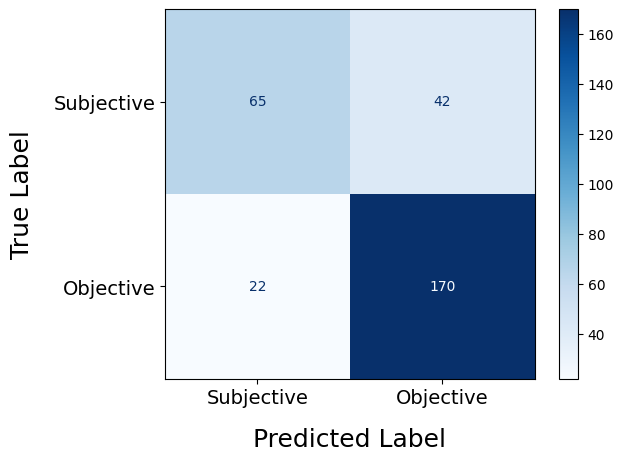

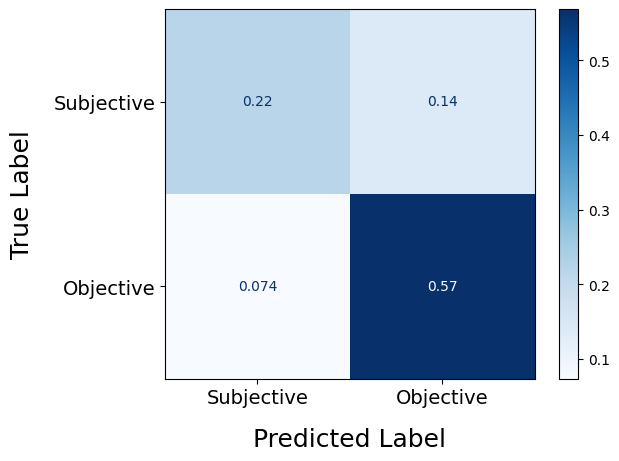

In [52]:
plot_confusion_matrix("ensemble", test_results)

#### Italian - ST

In [53]:
gold_file = "data/italian/test_it_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_st_mono_it_test_predictions.tsv"

In [54]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.7584
            macro-P: 0.7720
            macro-R: 0.7506
            
            SUBJ-F1: 0.6768
            SUBJ-P: 0.7363
            SUBJ-R: 0.6262
            
            accuracy: 0.7860
        


In [55]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [56]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [57]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [58]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 40

EXAMPLES:

	Tempo al tempo vedremo.

	L'ostentazione della burineria e servizi montani penosi.

	Poi il leader M5S è durissimo con il ministro Nordio:

	Conte infanga Meloni?

	Il Repower-EU ha provato a tracciare la rotta in merito all’indipendenza energetica, che tutto è tranne che autosufficienza dell’UE.

	Poi fatte le olimpiadi verrà abbondonata.

	Il sindaco Gianluca Lorenzi (domani a Milano per la festa dei -365 giorni alle Olimpiadi) si toglie un sassolino dalla scarpa («Tutti esaltavano il ghiaccio naturale di St. Moritz e volevano spostare i Giochi lì, ma la prova di Coppa del Mondo è stata appena cancellata per il caldo») e poi delinea un cronoprogramma super ambizioso:

	Capisco le polemiche, i soldi in gioco sono tanti, ma se c’è un luogo nelle Alpi che merita una pista è Cortina con i suoi cent’anni di tradizione bobbistica».

	l’offerta di Lake Placid che aveva ingolosito il Cio e umiliato noi italiani (viaggi e alberghi per gli 

In [59]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 24

EXAMPLES:

	Dare del tu e chiamarsi per nome, a seconda del contesto, della relazione esistente tra i parlanti, e di molti altri fattori variabili, possono essere un modo per esprimere empatia oppure un modo di interloquire inappropriato e irrispettoso.

	Meno di 100 anni fa, le donne non potevano votare, e sembrava normale, nello stesso modo in cui oggi sembra normale vedere un autobus nel traffico.

	In questo quadro di competizione e guerra che coinvolge innanzitutto il mercato energetico, la narrazione Italiana costruita dal Governo Meloni sulla “sicurezza energetica” si inserisce perfettamente.

	E' quindi ipotizzabile che si assista a una fase in cui oro e dollaro si muovono nella stessa direzione, senza necessariamente influenzarsi a vicenda.

	Tuttavia, questa relazione si è notevolmente attenuata.

	L’attitudine a darsi del tu e chiamarsi per nome più spesso che in passato non implica che sia sempre appropriato e inoffensivo farlo

	La

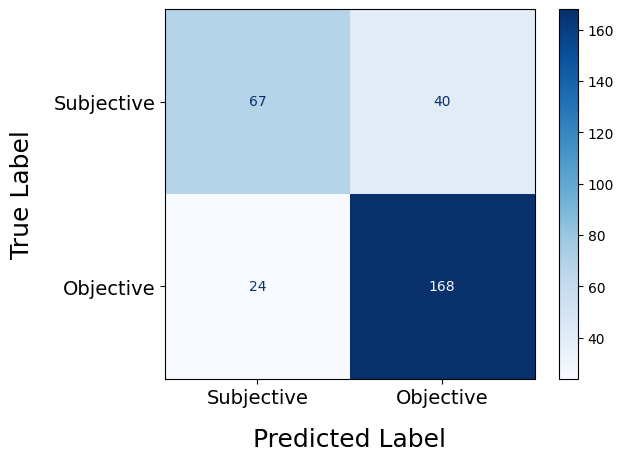

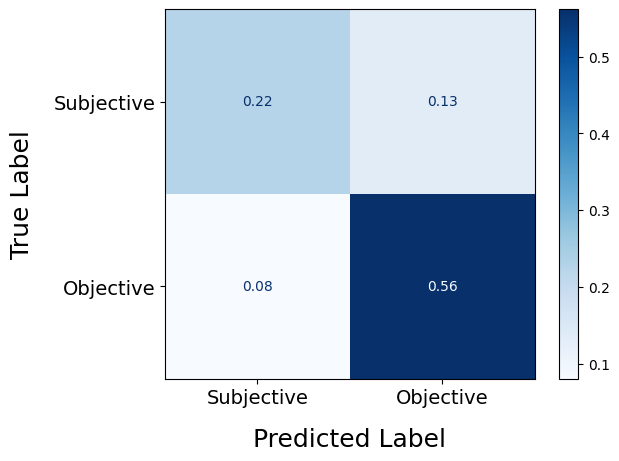

In [60]:
plot_confusion_matrix("ensemble", test_results)

### Multilungual

#### MV

In [61]:
gold_file = "data/multilingual/test_multilingual_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_mv_multilingual_test_predictions.tsv"

In [62]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.6839
            macro-P: 0.7333
            macro-R: 0.6700
            
            SUBJ-F1: 0.5279
            SUBJ-P: 0.6883
            SUBJ-R: 0.4281
            
            accuracy: 0.7608
        


In [63]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [64]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [65]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [66]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 354

EXAMPLES:

	Ecco ad esempio che la Regione Liguria, guidata dalla destra, ha pensato bene di stanziare 220mila euro per un progetto di educazione allaffettività nelle parrocchie e negli oratori.

	ويتطرق عمار إلى التأثيرات المحتملة لموقف ماسك ،  أن ذلك الموقف قد يفاقم التوتر بين واشنطن وبرلين ، خاصة في ظل حساسية المرحلة الحالية مع اقتراب الانتخابات في ألمانيا.

	Il fronte delle opposizioni va durissimo all'attacco della premier Giorgia Meloni e del governo nel dibattito alla Camera dopo le informative dei ministri Carlo Nordio e Matteo Piantedosi sul caso Almasri.

	Lone shoppers lined the aisles in preparation for a Government-mandated 24-hour indoors, with several baskets piled with more food, booze and toilet rolls than any household could conceivably need during such a short time.

	ويبدو أن مستوى الدوري الإنجليزي بشكل عام ونسق مانشستر يونايتد القوي هو السبب الأول في تعثر خطوات المجبري في فريق الشياطين الحمر وعدم قدرته على إثبات نفسه حتى 

In [67]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 120

EXAMPLES:

	From the lack of vision, the lack of hope.

	The fuel for the far right comes from disillusionment.

	I felt like I’d accomplished something creative for the first time in a long time.

	Reading about post-revolutionary cities, one often learns about the tension between the anticipation of the people and the dilapidation around them.

	I started writing fiction again for the first time in more than a decade, and it felt incredible.

	«Caro compagno, dammi pure del lei».

	أخبار ذات صلة اتهام دول وتجاهل أخرى.

	هل هي طموحات توسعية غير مسبوقة ، أم أنها مجرد أدوات تفاوضية تثير الجدل الإعلامي وتضغط على الخصوم لتحقيق مكاسب ؟

	In den großen Medien dominiert ein Steinwurf in Richtung eines ARD-Teams die Berichterstattung über die Corona-Großkundgebung.

	Den Gesetzentwurf zur Reform des Stiftungsrechts und den stiftungsrechtlichen Teil des Änderungsantrags begrüße man grundsätzlich, müsse ihn aber auf Grund der dargelegten Argumente in 

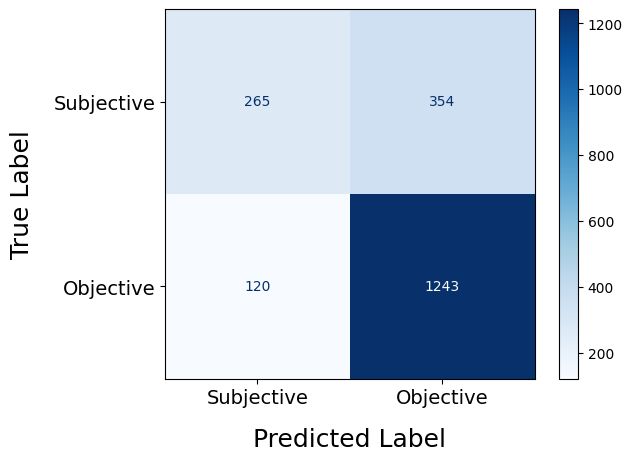

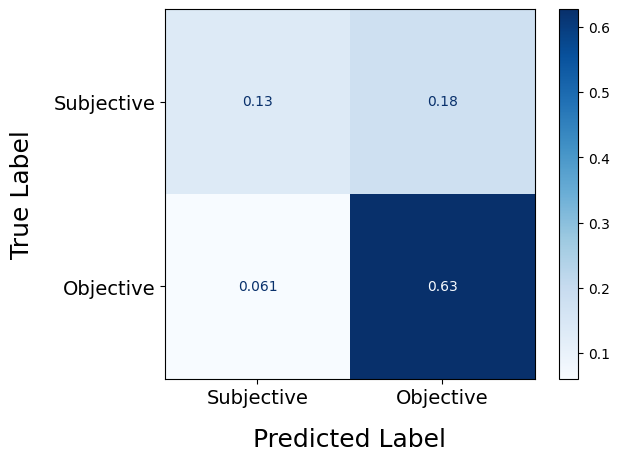

In [68]:
plot_confusion_matrix("ensemble", test_results)

#### PA

In [69]:
gold_file = "data/multilingual/test_multilingual_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_pa_multilingual_test_predictions.tsv"

In [70]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.6958
            macro-P: 0.7397
            macro-R: 0.6815
            
            SUBJ-F1: 0.5488
            SUBJ-P: 0.6938
            SUBJ-R: 0.4540
            
            accuracy: 0.7669
        


In [71]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [72]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [73]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [74]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 338

EXAMPLES:

	To these unhappy groups, we can add a third.

	Ecco ad esempio che la Regione Liguria, guidata dalla destra, ha pensato bene di stanziare 220mila euro per un progetto di educazione allaffettività nelle parrocchie e negli oratori.

	ويتطرق عمار إلى التأثيرات المحتملة لموقف ماسك ،  أن ذلك الموقف قد يفاقم التوتر بين واشنطن وبرلين ، خاصة في ظل حساسية المرحلة الحالية مع اقتراب الانتخابات في ألمانيا.

	Il fronte delle opposizioni va durissimo all'attacco della premier Giorgia Meloni e del governo nel dibattito alla Camera dopo le informative dei ministri Carlo Nordio e Matteo Piantedosi sul caso Almasri.

	Lone shoppers lined the aisles in preparation for a Government-mandated 24-hour indoors, with several baskets piled with more food, booze and toilet rolls than any household could conceivably need during such a short time.

	ويبدو أن مستوى الدوري الإنجليزي بشكل عام ونسق مانشستر يونايتد القوي هو السبب الأول في تعثر خطوات المجبري في فري

In [75]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 124

EXAMPLES:

	From the lack of vision, the lack of hope.

	أخبار ذات صلة " تيشاع بآف ".

	The fuel for the far right comes from disillusionment.

	ويبدو أنه يرى روسيا كمواطنة حاسمة في هذا المسعى.

	I felt like I’d accomplished something creative for the first time in a long time.

	Reading about post-revolutionary cities, one often learns about the tension between the anticipation of the people and the dilapidation around them.

	I started writing fiction again for the first time in more than a decade, and it felt incredible.

	«Caro compagno, dammi pure del lei».

	تساعد بكين مصر في بناء عاصمة جديدة بالكامل.

	أخبار ذات صلة اتهام دول وتجاهل أخرى.



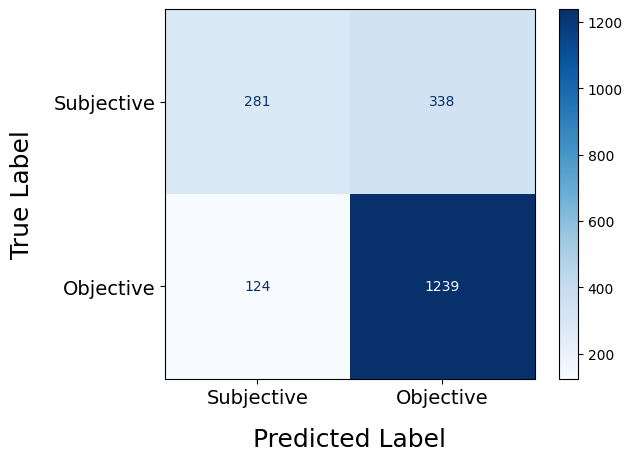

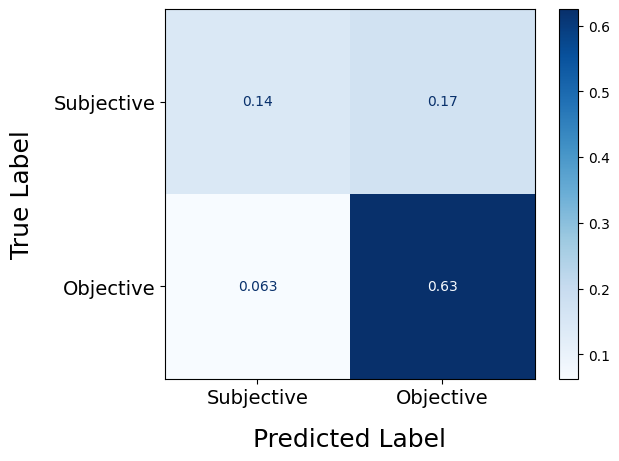

In [76]:
plot_confusion_matrix("ensemble", test_results)

#### ST

In [77]:
gold_file = "data/multilingual/test_multilingual_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_st_multilingual_test_predictions.tsv"

In [78]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.6839
            macro-P: 0.7333
            macro-R: 0.6700
            
            SUBJ-F1: 0.5279
            SUBJ-P: 0.6883
            SUBJ-R: 0.4281
            
            accuracy: 0.7608
        


In [79]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [80]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [81]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

In [82]:
false_positives = test_results[test_results["error_type"] == "False Positive"]
print(f"Number of False Positives (ensemble): {false_positives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_positives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Positives (ensemble): 354

EXAMPLES:

	Ecco ad esempio che la Regione Liguria, guidata dalla destra, ha pensato bene di stanziare 220mila euro per un progetto di educazione allaffettività nelle parrocchie e negli oratori.

	ويتطرق عمار إلى التأثيرات المحتملة لموقف ماسك ،  أن ذلك الموقف قد يفاقم التوتر بين واشنطن وبرلين ، خاصة في ظل حساسية المرحلة الحالية مع اقتراب الانتخابات في ألمانيا.

	Il fronte delle opposizioni va durissimo all'attacco della premier Giorgia Meloni e del governo nel dibattito alla Camera dopo le informative dei ministri Carlo Nordio e Matteo Piantedosi sul caso Almasri.

	Lone shoppers lined the aisles in preparation for a Government-mandated 24-hour indoors, with several baskets piled with more food, booze and toilet rolls than any household could conceivably need during such a short time.

	ويبدو أن مستوى الدوري الإنجليزي بشكل عام ونسق مانشستر يونايتد القوي هو السبب الأول في تعثر خطوات المجبري في فريق الشياطين الحمر وعدم قدرته على إثبات نفسه حتى 

In [83]:
false_negatives = test_results[test_results["error_type"] == "False Negative"]
print(f"Number of False Negatives (ensemble): {false_negatives.shape[0]}")
print("\nEXAMPLES:\n")
for ex in false_negatives.head(10).sentence:
    print(f"\t{ex}\n")

Number of False Negatives (ensemble): 120

EXAMPLES:

	From the lack of vision, the lack of hope.

	The fuel for the far right comes from disillusionment.

	I felt like I’d accomplished something creative for the first time in a long time.

	Reading about post-revolutionary cities, one often learns about the tension between the anticipation of the people and the dilapidation around them.

	I started writing fiction again for the first time in more than a decade, and it felt incredible.

	«Caro compagno, dammi pure del lei».

	أخبار ذات صلة اتهام دول وتجاهل أخرى.

	هل هي طموحات توسعية غير مسبوقة ، أم أنها مجرد أدوات تفاوضية تثير الجدل الإعلامي وتضغط على الخصوم لتحقيق مكاسب ؟

	In den großen Medien dominiert ein Steinwurf in Richtung eines ARD-Teams die Berichterstattung über die Corona-Großkundgebung.

	Den Gesetzentwurf zur Reform des Stiftungsrechts und den stiftungsrechtlichen Teil des Änderungsantrags begrüße man grundsätzlich, müsse ihn aber auf Grund der dargelegten Argumente in 

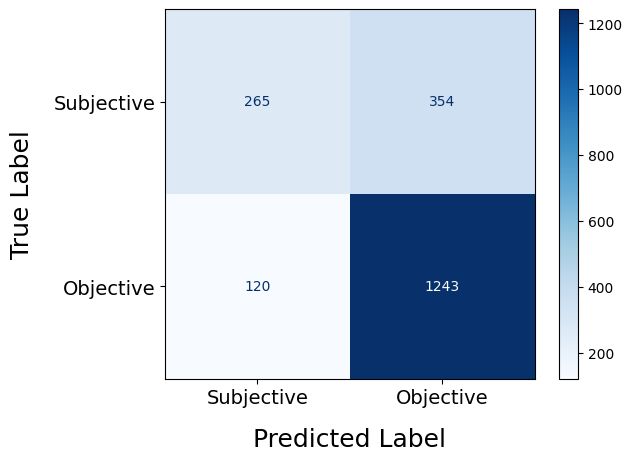

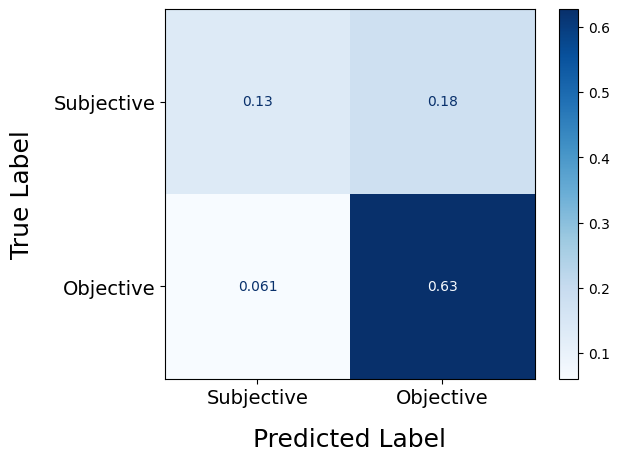

In [84]:
plot_confusion_matrix("ensemble", test_results)

### Zero-Shot

#### Greek

In [85]:
# During testing we found that two examples are classified as "Uncertain", so we decided to not consider these results.

#### Polish - MV

In [86]:
gold_file = "data/polish/test_pol_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_mv_zero_shot_pol_predictions.tsv"

In [87]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.5785
            macro-P: 0.7819
            macro-R: 0.6221
            
            SUBJ-F1: 0.4020
            SUBJ-P: 0.9535
            SUBJ-R: 0.2547
            
            accuracy: 0.6524
        


In [88]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [89]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [90]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

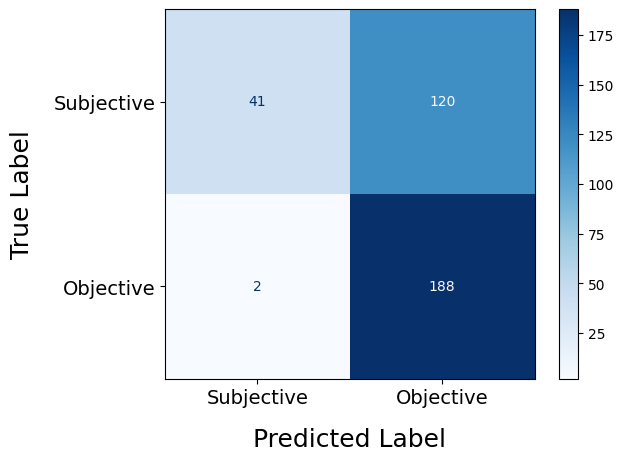

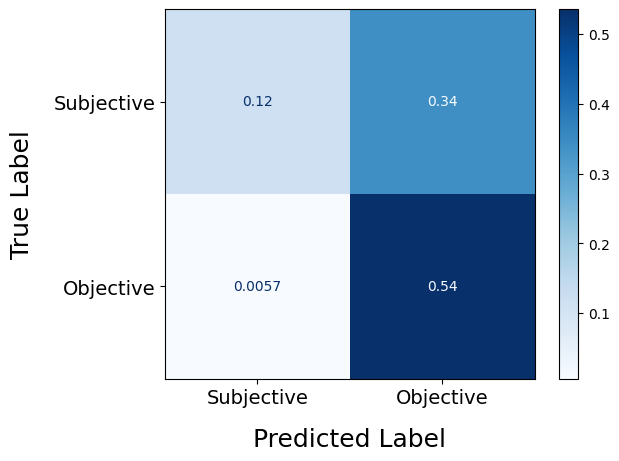

In [91]:
plot_confusion_matrix("ensemble", test_results)

#### Polish - PA

In [92]:
gold_file = "data/polish/test_pol_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_pa_zero_shot_pol_predictions.tsv"

In [93]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.5595
            macro-P: 0.7756
            macro-R: 0.6096
            
            SUBJ-F1: 0.3700
            SUBJ-P: 0.9487
            SUBJ-R: 0.2298
            
            accuracy: 0.6410
        


In [94]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [95]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [96]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

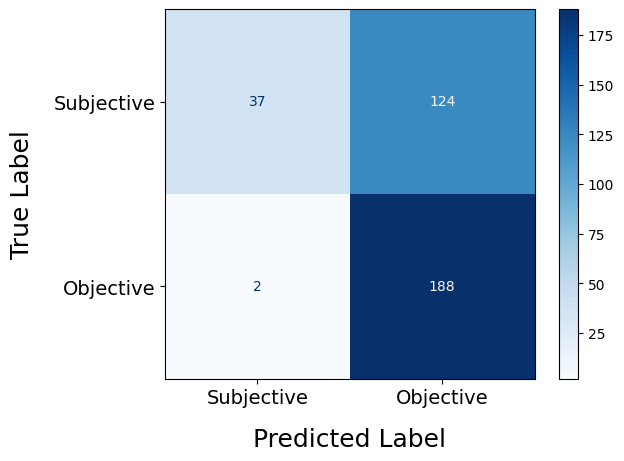

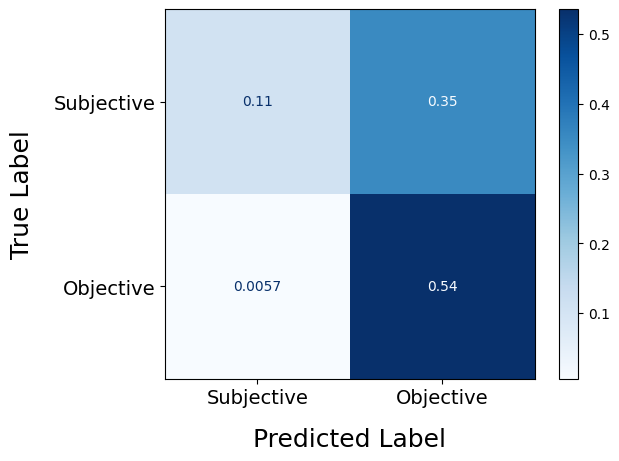

In [97]:
plot_confusion_matrix("ensemble", test_results)

#### Polish - ST

In [98]:
gold_file = "data/polish/test_pol_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_st_zero_shot_pol_predictions.tsv"

In [99]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.5785
            macro-P: 0.7819
            macro-R: 0.6221
            
            SUBJ-F1: 0.4020
            SUBJ-P: 0.9535
            SUBJ-R: 0.2547
            
            accuracy: 0.6524
        


In [100]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [101]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [102]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

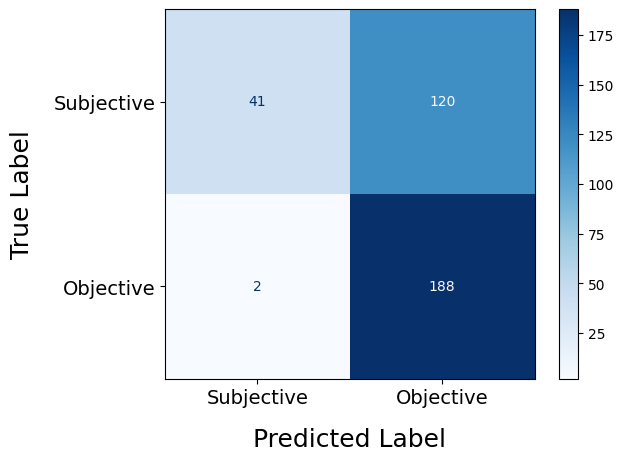

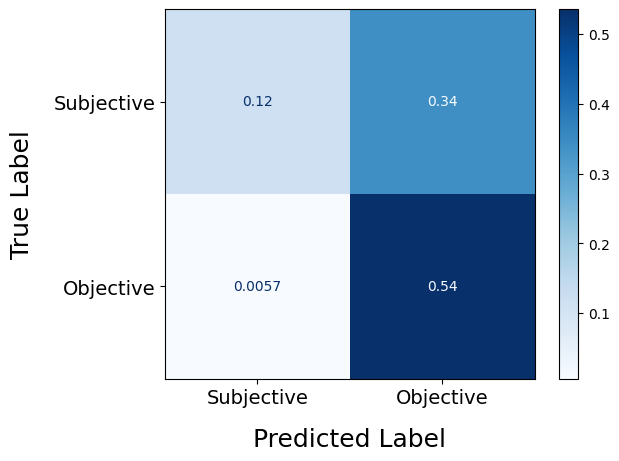

In [103]:
plot_confusion_matrix("ensemble", test_results)

#### Romanian - MV

In [104]:
gold_file = "data/romanian/test_ro_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_mv_zero_shot_ro_predictions.tsv"

In [105]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.7813
            macro-P: 0.7813
            macro-R: 0.7813
            
            SUBJ-F1: 0.6731
            SUBJ-P: 0.6731
            SUBJ-R: 0.6731
            
            accuracy: 0.8350
        


In [106]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [107]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [108]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

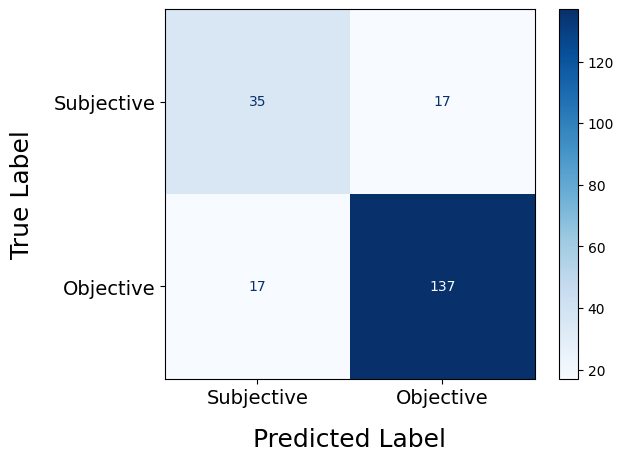

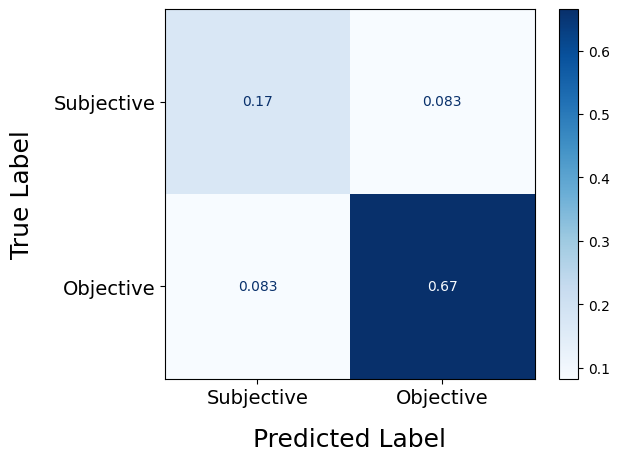

In [109]:
plot_confusion_matrix("ensemble", test_results)

#### Romanian - PA

In [110]:
gold_file = "data/romanian/test_ro_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_pa_zero_shot_ro_predictions.tsv"

In [111]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.7841
            macro-P: 0.7807
            macro-R: 0.7877
            
            SUBJ-F1: 0.6792
            SUBJ-P: 0.6667
            SUBJ-R: 0.6923
            
            accuracy: 0.8350
        


In [112]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [113]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [114]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

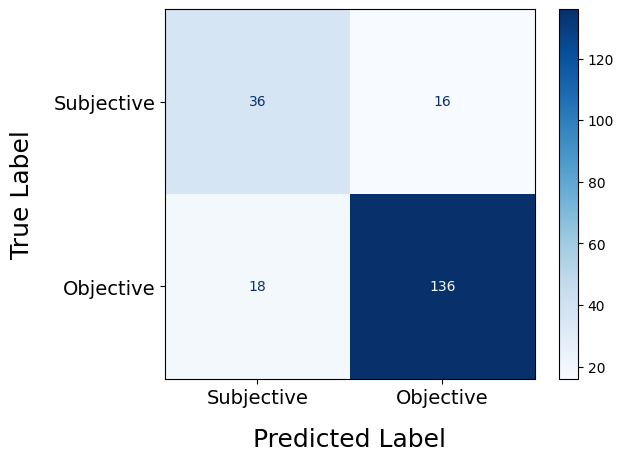

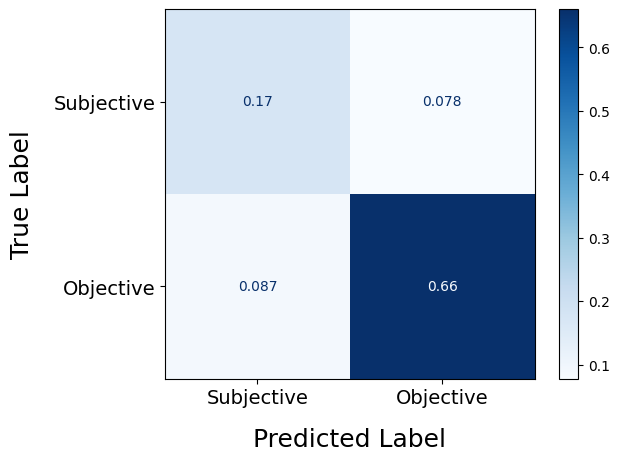

In [115]:
plot_confusion_matrix("ensemble", test_results)

#### Romanian - ST

In [116]:
gold_file = "data/romanian/test_ro_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_st_zero_shot_ro_predictions.tsv"

In [117]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.7813
            macro-P: 0.7813
            macro-R: 0.7813
            
            SUBJ-F1: 0.6731
            SUBJ-P: 0.6731
            SUBJ-R: 0.6731
            
            accuracy: 0.8350
        


In [118]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [119]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [120]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

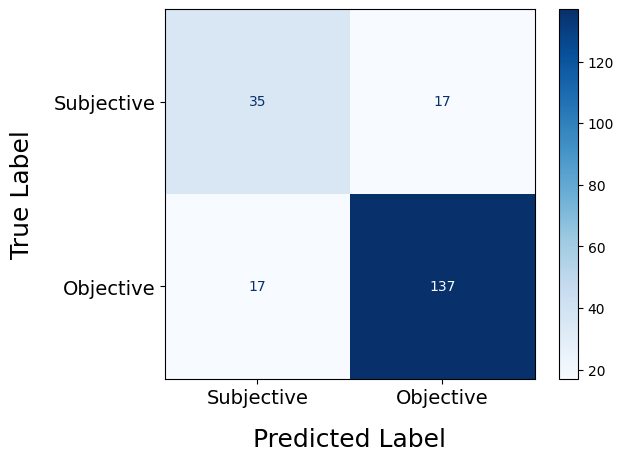

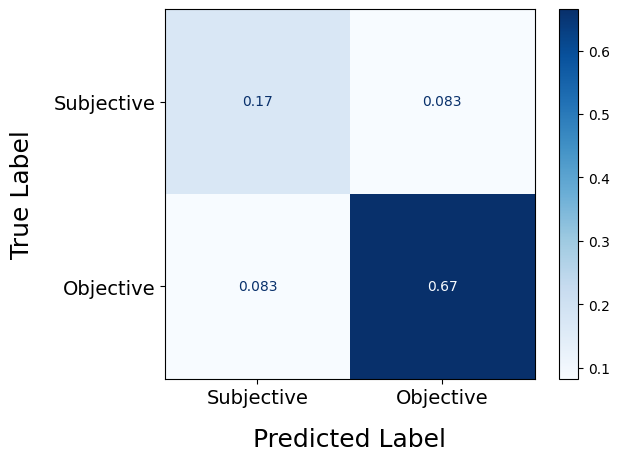

In [121]:
plot_confusion_matrix("ensemble", test_results)

#### Ukrainian - MV

In [122]:
gold_file = "data/ukrainian/test_ukr_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_mv_zero_shot_ukr_predictions.tsv"

In [123]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.6170
            macro-P: 0.6136
            macro-R: 0.6341
            
            SUBJ-F1: 0.4699
            SUBJ-P: 0.4095
            SUBJ-R: 0.5513
            
            accuracy: 0.6734
        


In [124]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [125]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [126]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

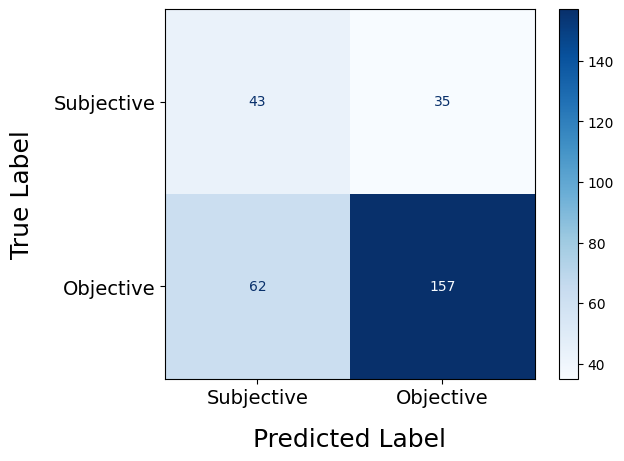

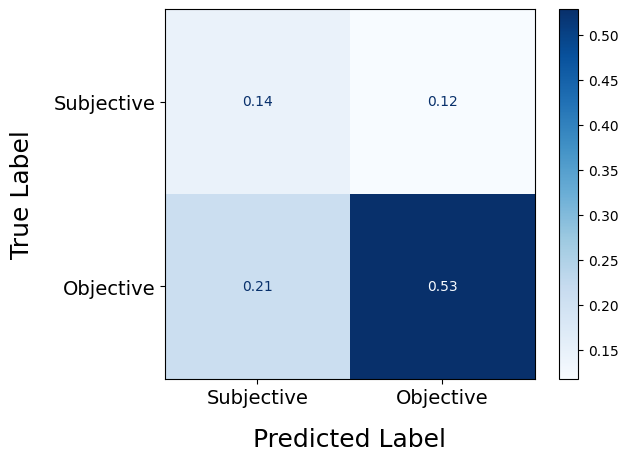

In [127]:
plot_confusion_matrix("ensemble", test_results)

#### Ukrainian - PA

In [128]:
gold_file = "data/ukrainian/test_ukr_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_pa_zero_shot_ukr_predictions.tsv"

In [129]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.6249
            macro-P: 0.6210
            macro-R: 0.6428
            
            SUBJ-F1: 0.4809
            SUBJ-P: 0.4190
            SUBJ-R: 0.5641
            
            accuracy: 0.6801
        


In [130]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [131]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [132]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

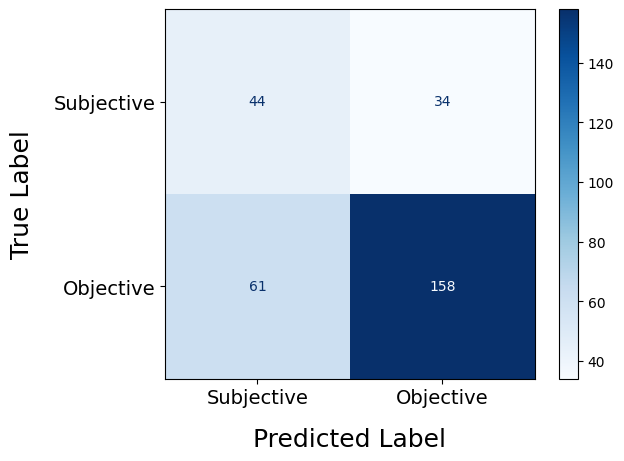

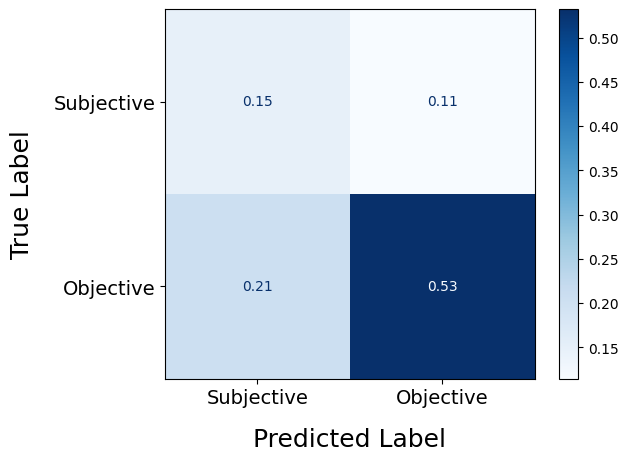

In [133]:
plot_confusion_matrix("ensemble", test_results)

#### Ukrainian - ST

In [134]:
gold_file = "data/ukrainian/test_ukr_labeled.tsv"
pred_file = "predictions/ensemble_predictions/ensemble_st_zero_shot_ukr_predictions.tsv"

In [135]:
# Run scorer
!python scorer/evaluate.py -g {gold_file} -p {pred_file}

INFO : The file is properly formatted
INFO : Started evaluating results for Task 1...
INFO : 
            macro-F1: 0.6170
            macro-P: 0.6136
            macro-R: 0.6341
            
            SUBJ-F1: 0.4699
            SUBJ-P: 0.4095
            SUBJ-R: 0.5513
            
            accuracy: 0.6734
        


In [136]:
# Load gold labels
df_gold = pd.read_csv(gold_file, sep="\t")  # adjust path as needed
df_gold["label"] = df_gold["label"].map({"OBJ": 1, "SUBJ": 0})  # Convert to numeric if not already
test_labels = df_gold["label"]

In [137]:
# Load predictions
df_pred = pd.read_csv(pred_file, sep="\t")
df_pred["label"] = df_pred["label"].map({"OBJ": 1, "SUBJ": 0})  # Ensure numeric labels
test_predictions = df_pred["label"]

In [138]:
# Combine into one DataFrame
test_results = pd.DataFrame({
    "sentence": df_gold["sentence"],
    "true_label": df_gold["label"],
    "predicted_label": df_pred["label"]
})

# Classify error types
test_results["error_type"] = np.where(
    test_results["true_label"] == test_results["predicted_label"],
    "Correct",
    np.where(
        (test_results["true_label"] == 1) & (test_results["predicted_label"] == 0),
        "False Negative",
        "False Positive"
    )
)

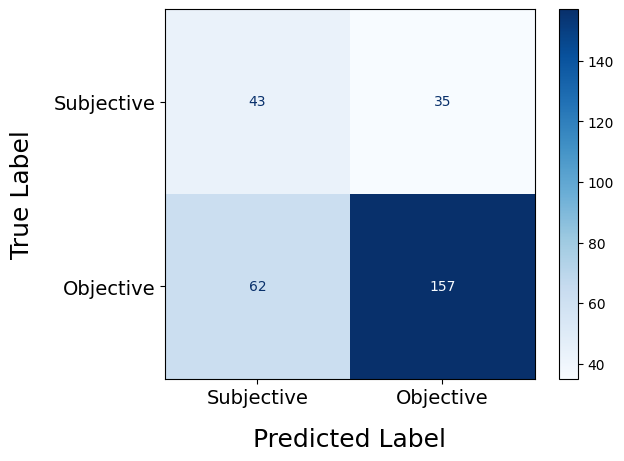

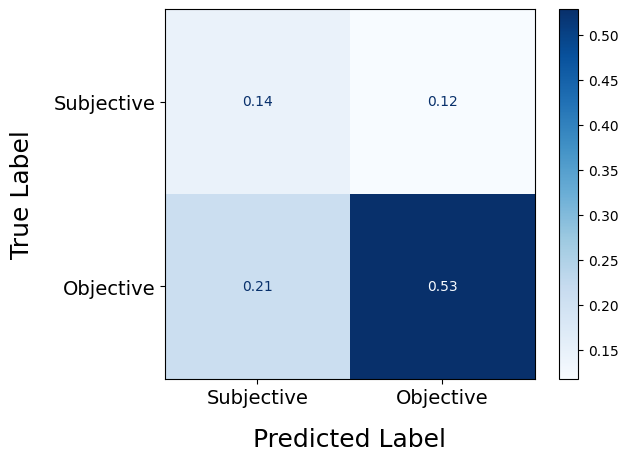

In [139]:
plot_confusion_matrix("ensemble", test_results)